In [ ]:
!pip install pandasql
!pip install tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from tokenizer.tokenizer import split_into_sentences
from torchtext.vocab import build_vocab_from_iterator
import torch
import numpy as np

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
import os
from google.colab import drive

path = 'drive/MyDrive/Colab Notebooks/'
speeches_2012 = os.path.join(path, 'speeches_2012.csv')
speeches_2013 = os.path.join(path, 'speeches_2013.csv')
speeches_2014 = os.path.join(path, 'speeches_2014.csv')
speeches_2015 = os.path.join(path, 'speeches_2015.csv')

In [ ]:
vocab_pth = os.path.join(path, 'vocab_final.pth')

In [ ]:
df_2012 = pd.read_csv(speeches_2012, names=['speech'], delimiter='{')
df_2013 = pd.read_csv(speeches_2013, names=['speech'], delimiter='{')
df_2014 = pd.read_csv(speeches_2014, names=['speech'], delimiter='{')
df_2015 = pd.read_csv(speeches_2015, names=['speech'], delimiter='{')

In [ ]:
df = pd.concat([df_2012, df_2013, df_2014, df_2015])
df.sample(frac=1)

,speech
9406,Hæstv. forseti . Ég þakka hv. þingmanni svarið...
5281,Virðulegur forseti . Einmitt vegna þeirra sjón...
10251,Herra forseti . Ég þakka fyrir jákvæðar undirt...
8410,Frú forseti . Ég held einmitt að þetta sé hlut...
5396,Hæstv. forseti . Þetta mál er þannig vaxið að ...
...,...
7335,Virðulegi forseti . Ég er fegin að heyra að Sj...
1247,Virðulegur forseti . Ég þakka hv. þingmanni fy...
7015,Virðulegi forseti . Ég mæli fyrir frumvarpi ti...
5862,Ég var ekki að segja …


(array([3.9730e+04, 3.1967e+04, 2.3740e+03, 1.9670e+03, 1.3550e+03,
        1.1230e+03, 1.0470e+03, 8.3300e+02, 6.7700e+02, 6.1800e+02,
        4.1400e+02, 2.9900e+02, 2.0800e+02, 1.3700e+02, 9.4000e+01,
        5.1000e+01, 4.9000e+01, 4.1000e+01, 4.6000e+01, 3.5000e+01,
        5.3000e+01, 2.8000e+01, 2.3000e+01, 2.4000e+01, 1.1000e+01,
        7.0000e+00, 9.0000e+00, 6.0000e+00, 7.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 1.196820e+03, 2.392640e+03, 3.588460e+03,
        4.784280e+03, 5.980100e+03, 7.175920e+03, 8.371740e+03,
        9.567560e+03, 1.076338e+04, 1.195920e+04, 1.315502e+04,
        1.435084e+04, 1.554666e+04, 1.674248e+04, 1.793830e+04,
        1.913412e+04, 2.032994e+04, 2.152576e+04, 2.272158e+04

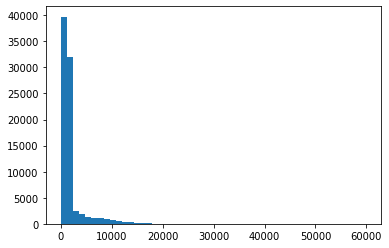

In [ ]:
plt.hist(df['speech'].str.len(), bins=50)

In [ ]:
df_snipped = pysqldf('select * from df where length(speech) > 500 and length(speech) < 3000')
df_snipped['speech'] = df_snipped['speech'].str.lower()

In [ ]:
df_train, df_test = train_test_split(df_snipped, test_size=0.10)

In [ ]:
def yield_tokens(speech):
  for text in speech:
    for s in (split_into_sentences(re.sub("[\(\[].*?[\)\]]", "", text))):
      yield(s.split())

vocab = build_vocab_from_iterator(yield_tokens(df_train.speech), specials = ['<unk>', '<bos>', '<eos>', '<pad>'], min_freq=10)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
torch.save(vocab, 'vocab_final.pth')

In [ ]:
len(vocab)

29772

In [ ]:
def text_pipeline(speech):
  r = []
  for s in (split_into_sentences(speech)):
      r.extend(s.split())
  return r

In [ ]:
vocab = torch.load(vocab_pth)

In [ ]:
def data_process(df):
  
  processed_data = []
  for index, row in df.iterrows():
    text = row[0]
    text_tensor = torch.tensor(vocab(text_pipeline(text)))
    if len(text_tensor) > 200:
      t_list = []
      text_t_r = text_tensor
      while True:
        indices = np.where(text_t_r == 5)[0]
        l = np.where(indices > 200)[0]
        if l.size > 1:
          text_t_s = text_t_r[:indices[l[0]]+1]
          text_t_r = text_t_r[indices[l[0]]+1:]
          t_list.append(text_t_s)
        else:
          t_list.append(text_t_r)
          break
      processed_data.extend(t_list)
    else:
      processed_data.append(text_tensor)

  return processed_data

train_data = data_process(df_train[['speech']].copy())
test_data = data_process(df_test[['speech']].copy())

In [ ]:
idx_to_word = vocab.get_itos()

def index_to_word(word):
  try:
    return idx_to_word[word]
  except KeyError:
    return '<unk>'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
BATCH_SIZE = 130
PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']



from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  text_list, label_list = [], []
  for text in data_batch:
    text_list.append(torch.cat((torch.tensor([BOS_IDX]), text), dim=0))
    label_list.append(torch.cat((text, torch.tensor([EOS_IDX])), dim=0))
  text_list = pad_sequence(text_list, padding_value=PAD_IDX)
  label_list = pad_sequence(label_list, padding_value=PAD_IDX)
  return text_list, label_list

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import nn
import numpy as np
class GenerationLSTM(nn.Module):
    def __init__(self):
        super(GenerationLSTM, self).__init__()
        self.lstm_size = 500
        self.embedding_dim = 300
        self.num_layers = 3

        n_vocab = len(vocab)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            padding_idx=PAD_IDX
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)

    
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, sequence_length):
        h = np.zeros((self.num_layers, sequence_length, self.lstm_size))
        c = np.zeros((self.num_layers, sequence_length, self.lstm_size))
        h.fill(0.5)
        c.fill(0.5)
        return (torch.tensor(h, dtype=torch.float32).to(device),
                torch.tensor(c, dtype=torch.float32).to(device))
        
    def init_state_p(self):
        return (torch.zeros(self.num_layers, self.lstm_size).to(device),
                torch.zeros(self.num_layers, self.lstm_size).to(device))

In [ ]:
train_losses = []
val_losses = []

In [ ]:
from torch import optim
import numpy as np

def train_w(dataloader, model):
    
    model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1, 30):
      losses =[]
      model.train()

      for idx, (text, label) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)

        state_h, state_c = model.init_state(text.shape[1])
        optimizer.zero_grad()
      
        y_pred, (state_h, state_c) = model(text, (state_h, state_c))
  
        loss = criterion(y_pred.transpose(1, 2), label)
        losses.append(loss.item())
        state_h = state_h.detach()
        state_c = state_c.detach()

        loss.backward()
        optimizer.step()

      print({ 'epoch': epoch, 'loss': sum(losses)/len(losses) })
      train_losses.append(sum(losses)/len(losses))
      evaluate(valid_iter, model)

def evaluate(dataloader, model):
    model.eval()
    model.to(device)
    losses = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
      print('eval')
      for idx, (text, label) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        state_h, state_c = model.init_state(text.shape[1])
    
      
        y_pred, (state_h, state_c) = model(text, (state_h, state_c))

        loss = criterion(y_pred.transpose(1, 2), label)
        losses.append(loss.item())


      print({'loss': sum(losses)/len(losses) })
      val_losses.append(sum(losses)/len(losses))
  

def predict_w(model, text, next_words=50):
    words = text.split(' ')
    model.eval()
    with torch.no_grad():
      state_h, state_c = model.init_state_p()
      
      for i in range(0, next_words):
          l = len(words)   
          x = torch.tensor(vocab(text_pipeline(words))).to(device)
          y_pred, (state_h, state_c) = model(x, (state_h, state_c))
          
          last_word_logits = nn.functional.softmax(y_pred[-1], dim=0)
      
          probs, maxk = torch.topk(last_word_logits, 3, dim=0)
        
          k = torch.multinomial(last_word_logits, 1)

          words.append(index_to_word(k))

    return words

In [ ]:
gen = GenerationLSTM()
gen = gen.to(device)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(gen):,} trainable parameters')

The model has 29,459,372 trainable parameters


In [ ]:
train_w(train_iter, gen)

In [ ]:
torch.save(vocab, 'vocab_new.pth')

In [ ]:
torch.save(gen, 'model_snipped.pth')

In [ ]:
torch.save(train_iter, 'train_data.pth')
torch.save(test_iter, 'test_data.pth')

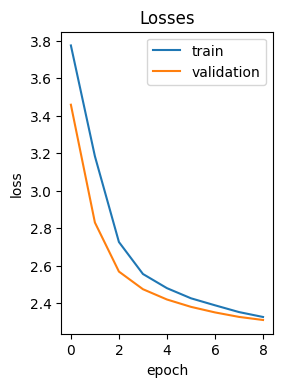

In [ ]:
from matplotlib import pyplot as plt
plt.figure(dpi=100)
plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()
plt.show()